## 1. Installations


In [1]:
!/usr/local/bin/python3 -m pip install -q --upgrade duckdb


In [2]:
!pip3 install --upgrade pip

In [3]:
pip install kagglehub[pandas-datasets] python-dotenv


zsh:1: no matches found: kagglehub[pandas-datasets]
Note: you may need to restart the kernel to use updated packages.


## 2. Imports


In [4]:
import os
import json
import pandas as pd
from pathlib import Path
from dotenv import load_dotenv
import kagglehub
from kagglehub import KaggleDatasetAdapter


/Library/Frameworks/Python.framework/Versions/3.13/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## 3. Downloads from Kaggle


In [5]:
load_dotenv()
print("USER:", os.getenv("KAGGLE_USERNAME"))
print("KEY:", "OK" if os.getenv("KAGGLE_KEY") else "MISSING")


USER: ananobre
KEY: OK


In [6]:
# Download latest version
path = kagglehub.dataset_download("computingvictor/transactions-fraud-datasets")

print("Path to dataset files:", path)

Path to dataset files: /Users/ananobre/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1


In [7]:
folder = "/Users/ananobre/.cache/kagglehub/datasets/computingvictor/transactions-fraud-datasets/versions/1"
print(os.listdir(folder))



['train_fraud_labels.json', 'mcc_codes.json', 'users_data.csv', 'transactions_data.csv', 'cards_data.csv']


## 4. Load Data


### 📶 users_data.csv

In [8]:
# CSVs
users = pd.read_csv(os.path.join(folder, "users_data.csv"))
transactions = pd.read_csv(os.path.join(folder, "transactions_data.csv"))
cards = pd.read_csv(os.path.join(folder, "cards_data.csv"))

# Checagem rápida
print("users:", users.shape, "| transactions:", transactions.shape, "| cards:", cards.shape)

users.head()


users: (2000, 14) | transactions: (13305915, 12) | cards: (6146, 13)


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards
0,825,53,66,1966,11,Female,462 Rose Lane,34.15,-117.76,$29278,$59696,$127613,787,5
1,1746,53,68,1966,12,Female,3606 Federal Boulevard,40.76,-73.74,$37891,$77254,$191349,701,5
2,1718,81,67,1938,11,Female,766 Third Drive,34.02,-117.89,$22681,$33483,$196,698,5
3,708,63,63,1957,1,Female,3 Madison Street,40.71,-73.99,$163145,$249925,$202328,722,4
4,1164,43,70,1976,9,Male,9620 Valley Stream Drive,37.76,-122.44,$53797,$109687,$183855,675,1


### 📶 transactions_data.csv"


In [9]:
transactions.head()


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors
0,7475327,2010-01-01 00:01:00,1556,2972,$-77.00,Swipe Transaction,59935,Beulah,ND,58523.0,5499,NaN
1,7475328,2010-01-01 00:02:00,561,4575,$14.57,Swipe Transaction,67570,Bettendorf,IA,52722.0,5311,NaN
2,7475329,2010-01-01 00:02:00,1129,102,$80.00,Swipe Transaction,27092,Vista,CA,92084.0,4829,NaN
3,7475331,2010-01-01 00:05:00,430,2860,$200.00,Swipe Transaction,27092,Crown Point,IN,46307.0,4829,NaN
4,7475332,2010-01-01 00:06:00,848,3915,$46.41,Swipe Transaction,13051,Harwood,MD,20776.0,5813,NaN



### 📶 cards_data.csv"

In [10]:
cards.head()

,id,client_id,card_brand,card_type,card_number,expires,cvv,has_chip,num_cards_issued,credit_limit,acct_open_date,year_pin_last_changed,card_on_dark_web
0,4524,825,Visa,Debit,4344676511950444,12/2022,623,YES,2,$24295,09/2002,2008,No
1,2731,825,Visa,Debit,4956965974959986,12/2020,393,YES,2,$21968,04/2014,2014,No
2,3701,825,Visa,Debit,4582313478255491,02/2024,719,YES,2,$46414,07/2003,2004,No
3,42,825,Visa,Credit,4879494103069057,08/2024,693,NO,1,$12400,01/2003,2012,No
4,4659,825,Mastercard,Debit (Prepaid),5722874738736011,03/2009,75,YES,1,$28,09/2008,2009,No



### 📶 mcc_codes.json

In [11]:
# JSONs (dict simples -> vira duas colunas)
with open(os.path.join(folder, "mcc_codes.json"), "r", encoding="utf-8") as f:
    mcc_codes = pd.DataFrame(list(json.load(f).items()), columns=["mcc", "mcc_description"])

with open(os.path.join(folder, "train_fraud_labels.json"), "r", encoding="utf-8") as f:
    fraud_labels = pd.DataFrame(list(json.load(f).items()), columns=["transaction_id", "is_fraud"])

# Checagem rápida
print("mcc_codes:", mcc_codes.shape, "| fraud_labels:", fraud_labels.shape)

mcc_codes.head()



mcc_codes: (109, 2) | fraud_labels: (1, 2)


,mcc,mcc_description
0,5812,Eating Places and Restaurants
1,5541,Service Stations
2,7996,"Amusement Parks, Carnivals, Circuses"
3,5411,"Grocery Stores, Supermarkets"
4,4784,Tolls and Bridge Fees


### 📶 train_fraud_labels.json

In [12]:
fraud_labels.head()

,transaction_id,is_fraud
0,target,"{'10649266': 'No', '23410063': 'No', '9316588'..."


## 5. Exploratory Data Analysis (EDA)


In [13]:
for name, df in {
    "users": users, 
    "transactions": transactions, 
    "cards": cards, 
    "fraud_labels": fraud_labels, 
    "mcc_codes": mcc_codes
}.items():
    print(f"\n{name.upper()} -> {df.shape}")
    print(df.dtypes)
    print(df.head(3))



USERS -> (2000, 14)
id                     int64
current_age            int64
retirement_age         int64
birth_year             int64
birth_month            int64
gender                object
address               object
latitude             float64
longitude            float64
per_capita_income     object
yearly_income         object
total_debt            object
credit_score           int64
num_credit_cards       int64
dtype: object
     id  current_age  retirement_age  birth_year  birth_month  gender  \
0   825           53              66        1966           11  Female   
1  1746           53              68        1966           12  Female   
2  1718           81              67        1938           11  Female   

                  address  latitude  longitude per_capita_income  \
0           462 Rose Lane     34.15    -117.76            $29278   
1  3606 Federal Boulevard     40.76     -73.74            $37891   
2         766 Third Drive     34.02    -117.89            $226

### 🔎 users_data.csv

In [14]:
cols_to_convert = ["per_capita_income", "yearly_income", "total_debt"]

for col in cols_to_convert:
    users[col] = users[col].replace(r'[\$,]', '', regex=True).astype(float)


In [15]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 2000 non-null   int64  
 1   current_age        2000 non-null   int64  
 2   retirement_age     2000 non-null   int64  
 3   birth_year         2000 non-null   int64  
 4   birth_month        2000 non-null   int64  
 5   gender             2000 non-null   object 
 6   address            2000 non-null   object 
 7   latitude           2000 non-null   float64
 8   longitude          2000 non-null   float64
 9   per_capita_income  2000 non-null   float64
 10  yearly_income      2000 non-null   float64
 11  total_debt         2000 non-null   float64
 12  credit_score       2000 non-null   int64  
 13  num_credit_cards   2000 non-null   int64  
dtypes: float64(5), int64(7), object(2)
memory usage: 218.9+ KB


In [16]:
# Contar duplicados
users["id"].duplicated().sum()

# Ver IDs duplicados (se existirem)
users[users["id"].duplicated()]


,id,current_age,retirement_age,birth_year,birth_month,gender,address,latitude,longitude,per_capita_income,yearly_income,total_debt,credit_score,num_credit_cards


In [17]:
users.columns


Index(['id', 'current_age', 'retirement_age', 'birth_year', 'birth_month',
       'gender', 'address', 'latitude', 'longitude', 'per_capita_income',
       'yearly_income', 'total_debt', 'credit_score', 'num_credit_cards'],
      dtype='object')

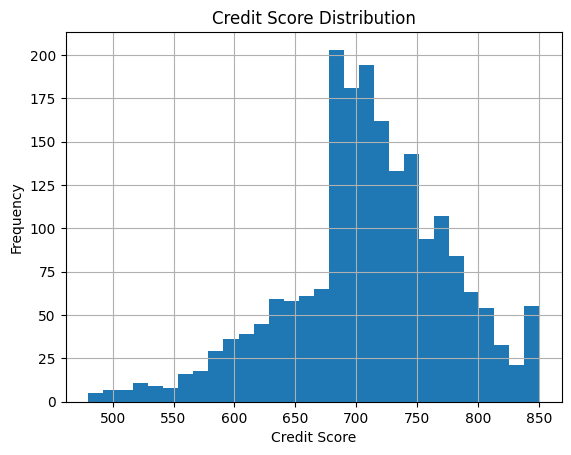

In [18]:
# Estatísticas descritivas
users[["current_age", "retirement_age", "credit_score", "num_credit_cards",
       "per_capita_income", "yearly_income", "total_debt"]].describe()

# Histograma para checar distribuição
import matplotlib.pyplot as plt

users["credit_score"].hist(bins=30)
plt.title("Credit Score Distribution")
plt.xlabel("Credit Score")
plt.ylabel("Frequency")
plt.show()


In [19]:
# proporção de valores nulos em cada coluna do users
users.isna().mean().sort_values(ascending=False)


id                   0.0
current_age          0.0
retirement_age       0.0
birth_year           0.0
birth_month          0.0
gender               0.0
address              0.0
latitude             0.0
longitude            0.0
per_capita_income    0.0
yearly_income        0.0
total_debt           0.0
credit_score         0.0
num_credit_cards     0.0
dtype: float64

### 🔎 transactions_data.csv"


In [20]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13305915 entries, 0 to 13305914
Data columns (total 12 columns):
 #   Column          Dtype  
---  ------          -----  
 0   id              int64  
 1   date            object 
 2   client_id       int64  
 3   card_id         int64  
 4   amount          object 
 5   use_chip        object 
 6   merchant_id     int64  
 7   merchant_city   object 
 8   merchant_state  object 
 9   zip             float64
 10  mcc             int64  
 11  errors          object 
dtypes: float64(1), int64(5), object(6)
memory usage: 1.2+ GB


In [21]:
# date → datetime
transactions["date"] = pd.to_datetime(transactions["date"], errors="coerce")

# amount: remover $ e , mantendo o sinal
transactions["amount"] = (
    transactions["amount"]
      .replace(r'[\$,]', '', regex=True)
      .astype(float)
)

# mcc como inteiro "nullable"
transactions["mcc"] = transactions["mcc"].astype("Int64")

# zip em string (preserva zeros à esquerda quando houver)
transactions["zip"] = transactions["zip"].astype("Int64").astype("string")


In [22]:
# ids duplicados 
transactions["id"].duplicated().sum()


np.int64(0)

In [23]:
transactions[transactions["id"].duplicated(keep=False)].sort_values("id")


,id,date,client_id,card_id,amount,use_chip,merchant_id,merchant_city,merchant_state,zip,mcc,errors


In [24]:
# existência das chaves estrangeiras
set(["client_id", "card_id"]).issubset(transactions.columns)


True

In [25]:
transactions.isna().mean().sort_values(ascending=False)


errors            0.984113
zip               0.124208
merchant_state    0.117519
id                0.000000
card_id           0.000000
client_id         0.000000
date              0.000000
amount            0.000000
merchant_city     0.000000
merchant_id       0.000000
use_chip          0.000000
mcc               0.000000
dtype: float64

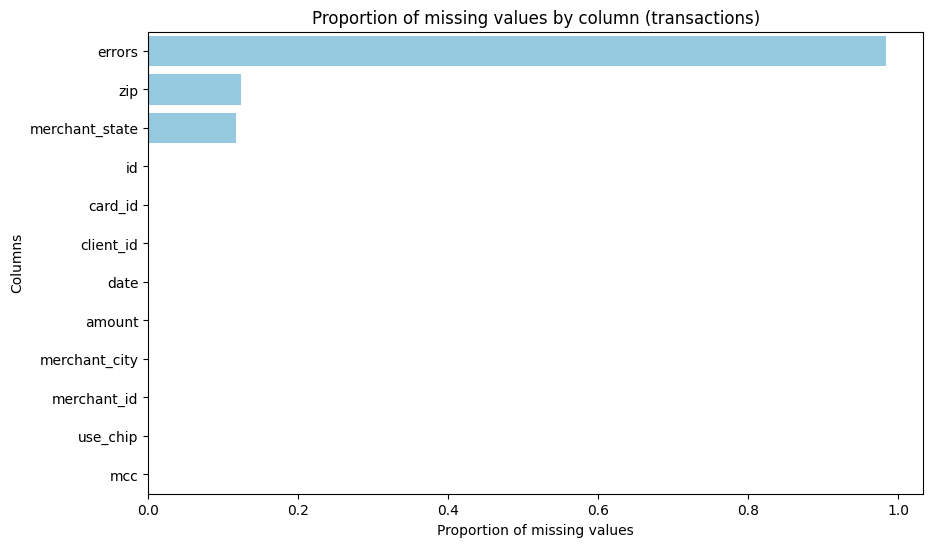

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# proporção de nulos por coluna
na_ratio = transactions.isna().mean().sort_values(ascending=False)

# tabela
na_ratio

# gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(x=na_ratio.values, y=na_ratio.index, color="skyblue")
plt.title("Proportion of missing values by column (transactions)")
plt.xlabel("Proportion of missing values")
plt.ylabel("Columns")
plt.show()


In [27]:
# Create binary flag
transactions["has_error"] = transactions["errors"].notna().astype(int)

# Count 0s and 1s
transactions["has_error"].value_counts()


has_error
0    13094522
1      211393
Name: count, dtype: int64

In [28]:
transactions["has_error"].value_counts(normalize=True).mul(100).round(2)

# The column errors in the transactions dataset shows ~100% missing values. 
# This is not necessarily a data quality issue — it is most likely a sparse field that is only filled when a transaction actually contains an error. By default, almost all transactions are error-free. 
# A better approach is to convert it into a binary flag (0 = no error, 1 = error).


has_error
0    98.41
1     1.59
Name: proportion, dtype: float64

In [29]:
transactions["has_error"] = transactions["has_error"].map({0: "No", 1: "Yes"})

# distribuição
transactions["has_error"].value_counts()



has_error
No     13094522
Yes      211393
Name: count, dtype: int64

In [30]:
# checagens rápidas
checks = {
    "datas_validas": transactions["date"].notna().all(),
    "amount_tem_negativos": (transactions["amount"] < 0).any(),  # pode indicar estorno
    "mcc_na_faixa": transactions["mcc"].dropna().between(1000, 9999).all(),  # regra comum de MCC
}
checks


{'datas_validas': np.True_,
 'amount_tem_negativos': np.True_,
 'mcc_na_faixa': np.True_}

In [31]:
transactions["date_only"] = transactions["date"].dt.date
transactions["week"] = transactions["date"].dt.isocalendar().week.astype(int)
transactions["month"] = transactions["date"].dt.to_period("M").astype(str)
transactions["dow"] = transactions["date"].dt.day_name()   # dia da semana
transactions["hour"] = transactions["date"].dt.hour


In [32]:
LAUNCH_DATE = pd.Timestamp("2010-06-01")
transactions["period"] = np.where(transactions["date"] < LAUNCH_DATE, "pre", "post")
transactions["period"] = pd.Categorical(transactions["period"], categories=["pre","post"], ordered=True)


NameError: name 'np' is not defined

In [ ]:
# selecionar colunas que vão para o analítico (ajuste conforme necessidade)
tx_cols = [
    "id","date","date_only","week","month","dow","hour",
    "client_id","card_id","amount","use_chip","merchant_id",
    "merchant_city","merchant_state","zip","mcc","errors","period"
]
transactions_clean = transactions[tx_cols].copy()
transactions_clean.head()



### 🔎 cards_data.csv"

In [ ]:
transactions.columns


Index(['id', 'date', 'client_id', 'card_id', 'amount', 'use_chip',
       'merchant_id', 'merchant_city', 'merchant_state', 'zip', 'mcc',
       'errors'],
      dtype='object')

In [ ]:
cards.columns


Index(['id', 'client_id', 'card_brand', 'card_type', 'card_number', 'expires',
       'cvv', 'has_chip', 'num_cards_issued', 'credit_limit', 'acct_open_date',
       'year_pin_last_changed', 'card_on_dark_web'],
      dtype='object')

In [ ]:
fraud_labels.columns


Index(['transaction_id', 'is_fraud'], dtype='object')

In [ ]:
mcc_codes.columns


Index(['mcc', 'mcc_description'], dtype='object')

In [ ]:
df = (
    transactions
    .merge(users, left_on="client_id", right_on="id", how="left", suffixes=("", "_user"))
    .merge(cards, left_on="card_id", right_on="id", how="left", suffixes=("", "_card"))
    .merge(fraud_labels, left_on="id", right_on="transaction_id", how="left")
    .merge(mcc_codes, on="mcc", how="left")
)
print(df.shape)
df.head()
